# DATA2001 Assingment 3

## Data Preparation

In [158]:
import pandas as pd
import numpy as np

df = pd.read_csv("amzn.us.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [159]:
print(type(df['Date'][2])) 

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


**Exogenous Data: VIX Index**

"Volatility Index, a popular measure of the stock market's expectation of volatility based on S&P 500 index options. It is calculated and disseminated on a real-time basis by the CBOE, and is often referred to as the fear index or fear gauge." Source: [Wikipedia](https://en.wikipedia.org/wiki/VIX)

It is useful exogenous variable because it gives a broad sense of the state the world in relation to the market. It is highly correlated to news events that are expected to negativly effect markets. In this case it is presented as a 30-day expection of volatility given a weighted portfolio of european options on the S&P 500. Its sourced from  [Yahoo Finance](https://finance.yahoo.com/quote/%5EVIX?p=%5EVIX) for the relevant period. 

In [160]:
vix = pd.read_csv('VIX.csv')
vix.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-16,18.730000,21.820000,18.580000,21.570000,21.570000,0
1,1997-05-19,21.879999,21.950001,21.260000,21.480000,21.480000,0
2,1997-05-20,21.490000,21.719999,19.129999,19.260000,19.260000,0
3,1997-05-21,19.190001,19.620001,18.820000,19.280001,19.280001,0
4,1997-05-22,19.010000,19.240000,18.680000,18.770000,18.770000,0


In [161]:
#Dropping unneeded columns and keeping close for merge with amazon dataset
vix=vix['Close']
vix = vix.rename('VIXClose')
df['VIX Close']= vix

# Exploratory Analysis

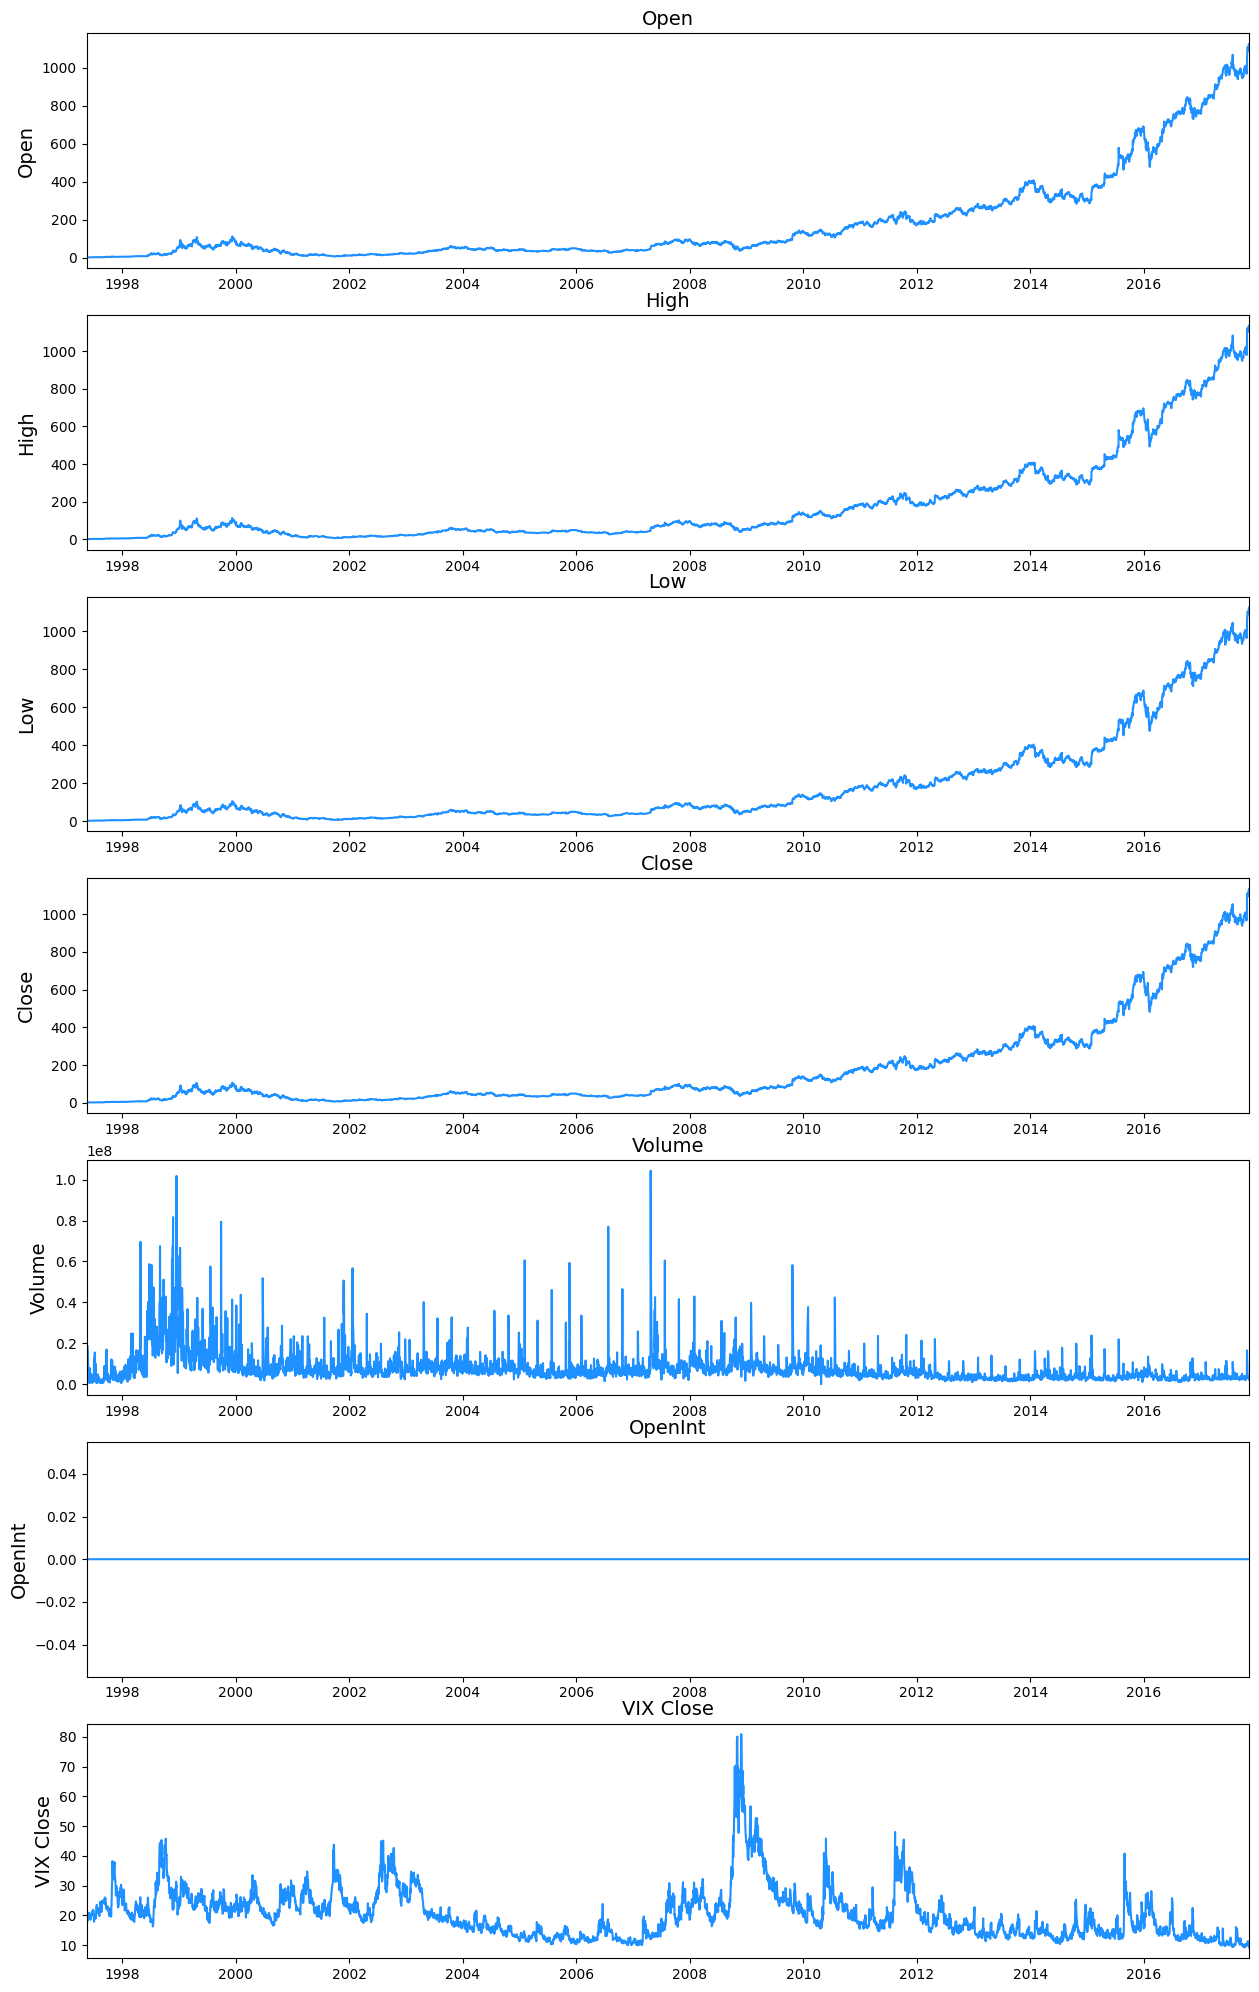

In [162]:
import seaborn as sns 
from datetime import datetime, date 

f, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlabel('')
                      
    ax[i].set_xlim([date(1997, 5, 16), date(2017, 11, 9)])      

Some comments on the patterns visible. 

# Decomposition 

In [163]:
# Split data into training and test sets
train = df.iloc[:5081,:]
test = df.iloc[5081:,:]

### Isolating Trend

/tmp/ipykernel_1002404/865749639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['MA-60'] = train['Volume'].rolling(60).mean()
/tmp/ipykernel_1002404/865749639.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['MA-120'] = train['Volume'].rolling(120).mean()


<AxesSubplot:>

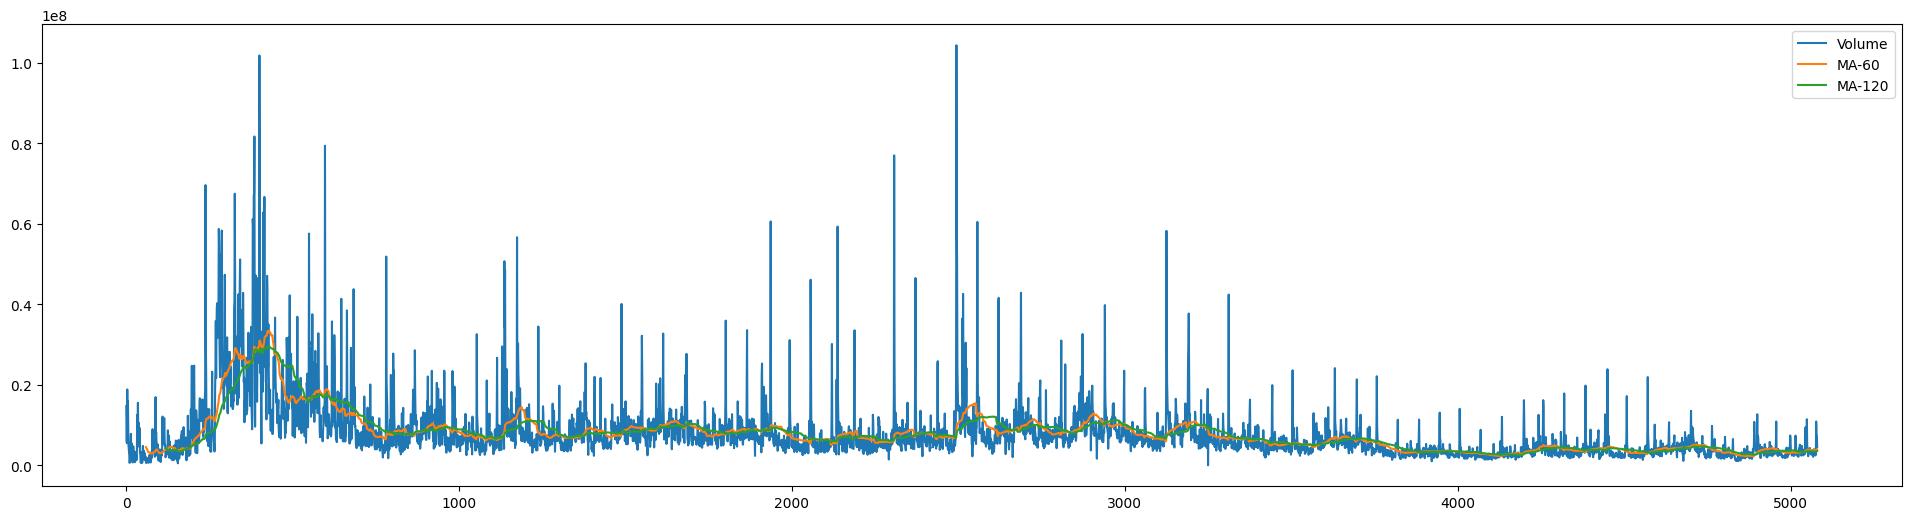

In [167]:
# There are 5 observations per week
train['MA-60'] = train['Volume'].rolling(60).mean()
train['MA-120'] = train['Volume'].rolling(120).mean()

train[['Volume','MA-60','MA-120']].plot(figsize=(24,6))

The MA-120 appears to be too long. You can determine this by observings the effect big changes have on it and how it appears to 'lag' a little more then MA-60.


### De-trending

/tmp/ipykernel_1002404/3329844735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vol-detrended'] = train['Volume'] - train['MA-120']


<AxesSubplot:>

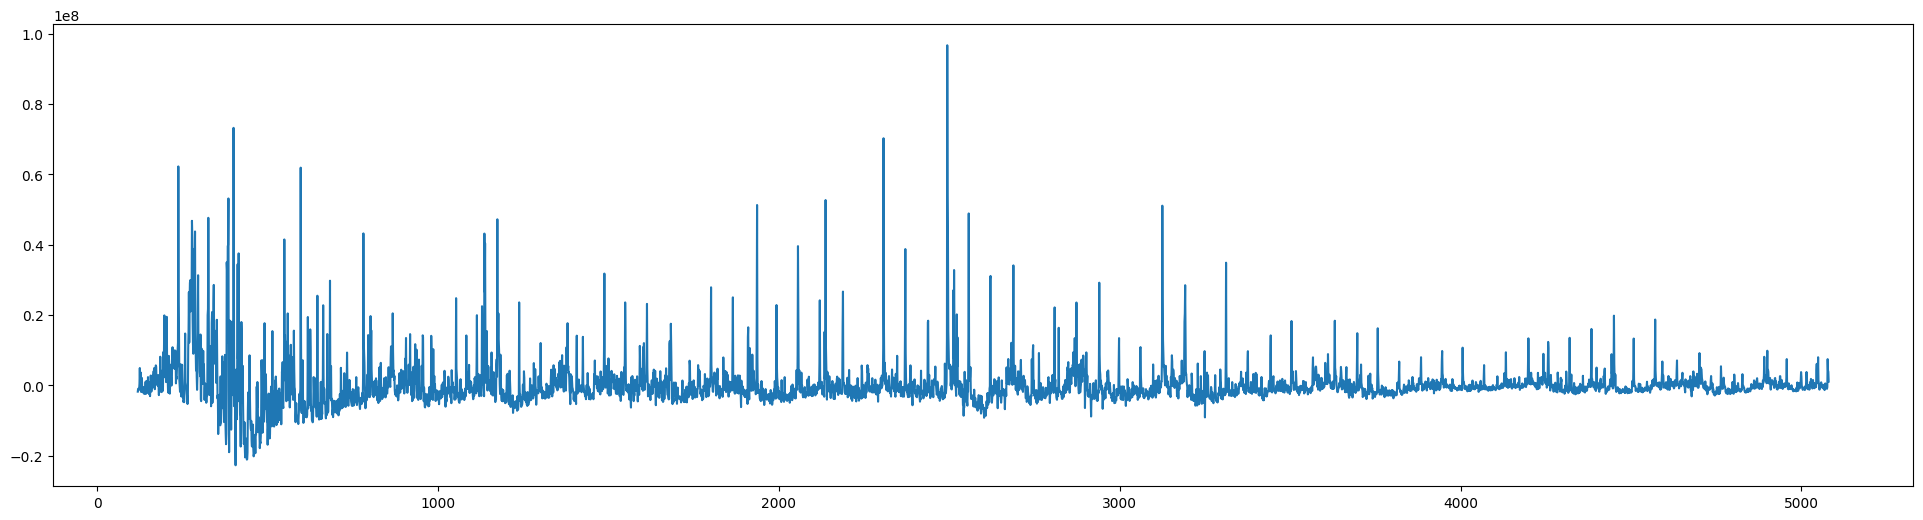

In [168]:
train['vol-detrended'] = train['Volume'] - train['MA-120']
train['vol-detrended'].plot(figsize=(24,6))

### Seasonality Component 

/tmp/ipykernel_1002404/1608321013.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vol-seasonal'] = result._seasonal


<AxesSubplot:>

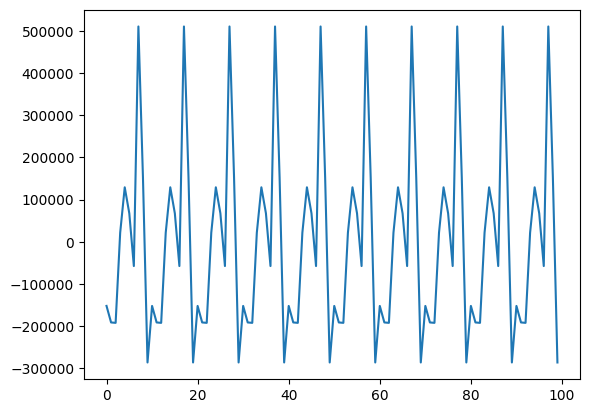

In [202]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['Volume'], model='additive',period=10)

train['vol-seasonal'] = result._seasonal
result._seasonal[:100].plot()

### Residual

/tmp/ipykernel_1002404/515467301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['vol-residual'] = train['vol-detrended'] - train['vol-seasonal']


<AxesSubplot:>

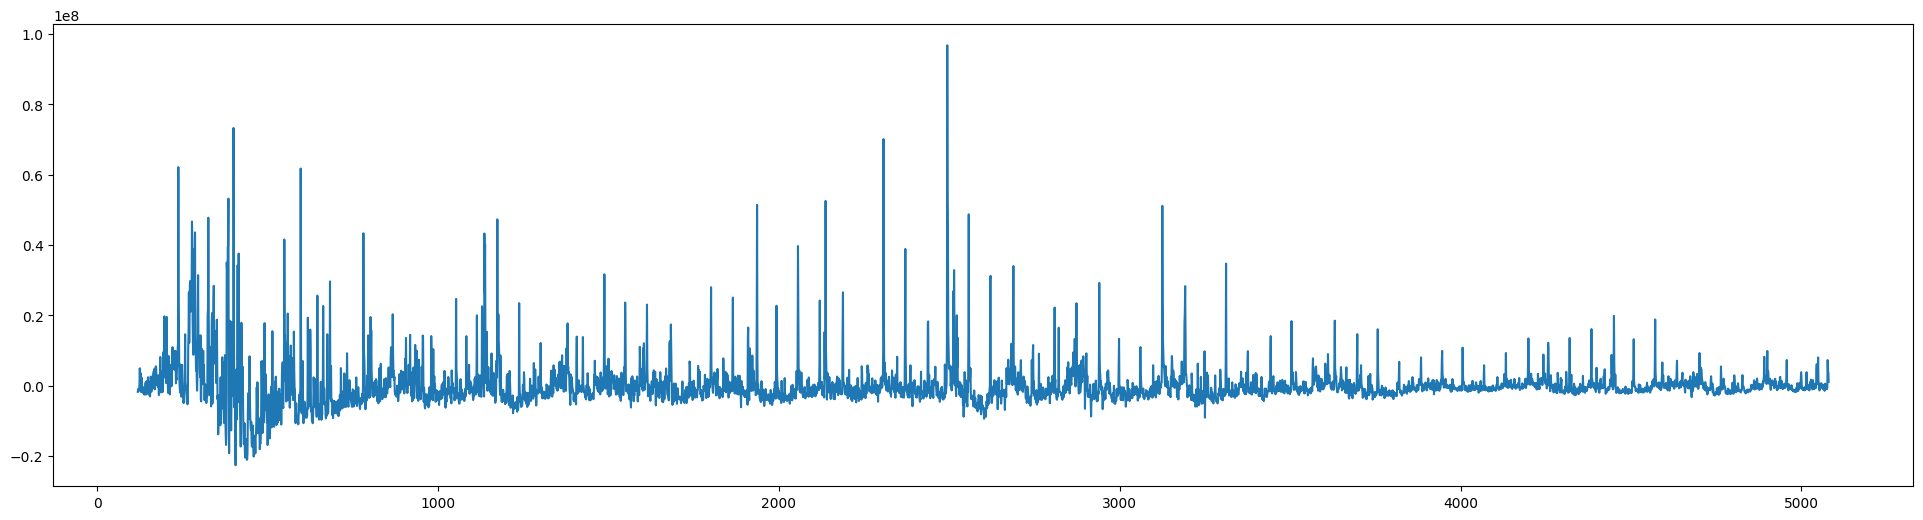

In [170]:
train['vol-residual'] = train['vol-detrended'] - train['vol-seasonal']
train['vol-residual'].plot(figsize=(24,6))

### Manual Decomposition Results


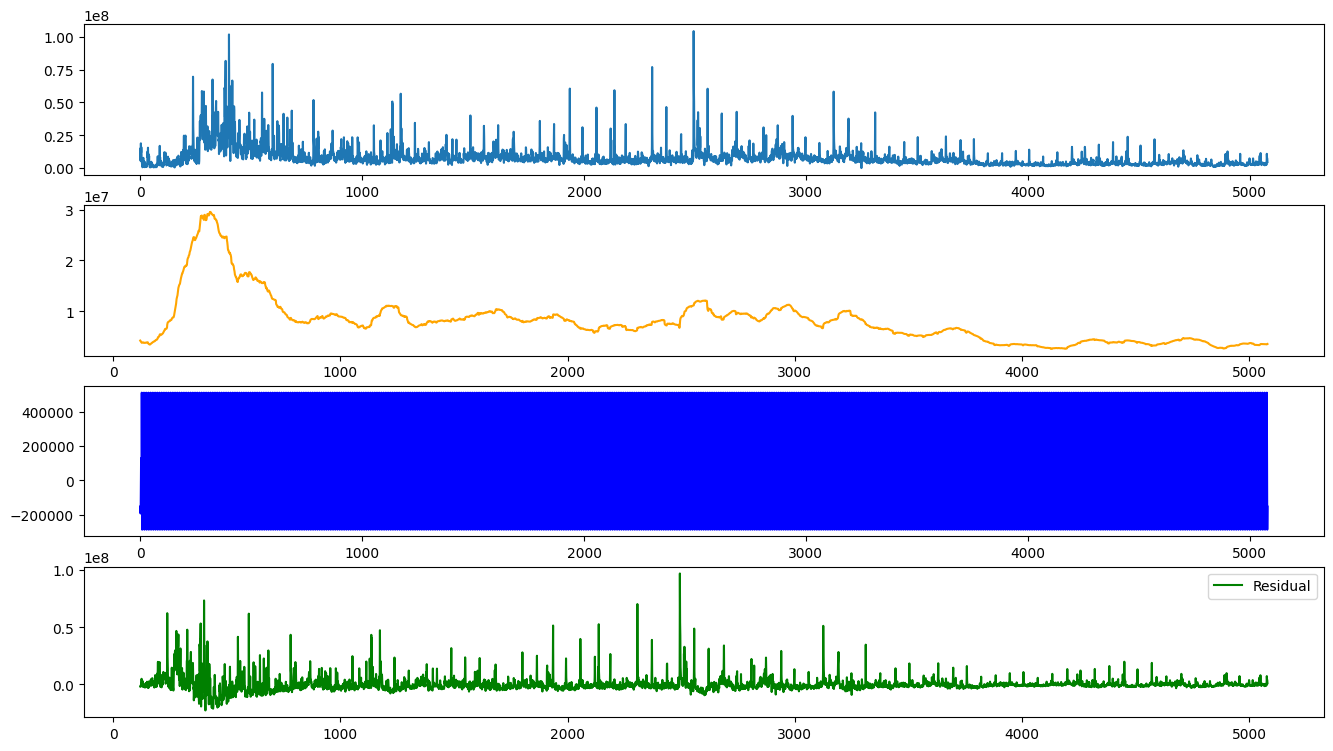

In [203]:
import matplotlib.pyplot as plt
fig, ax_str = plt.subplots(4)
train['Volume'].plot(label='Original', ax=ax_str[0])
train['MA-120'].plot(color='orange', label='MA-120 Trend', ax=ax_str[1])
train['vol-seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
train['vol-residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

### Automatic Decomposition  

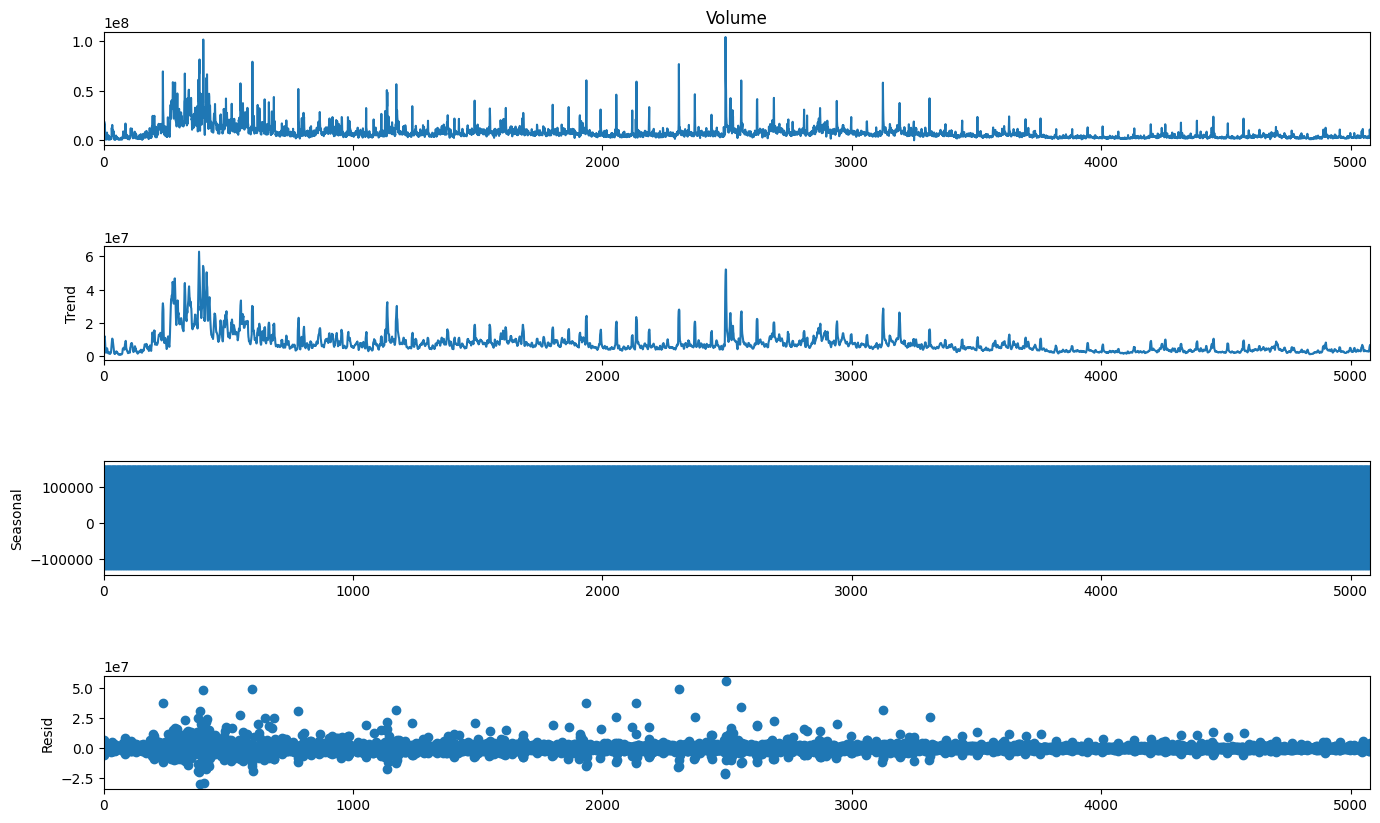

In [204]:
from statsmodels.tsa.seasonal import seasonal_decompose

str_res = seasonal_decompose(train['Volume'],period = 5)
fig = str_res.plot()
fig.set_size_inches((16, 9))

Some comments on the manual vs automatic. 

# ARIMA Model

### Stationarity?

Data needs to be stationary for ARIMA to be accurate. This means that it is:
- has a constant variance 
- patternless over time 
- roughly horizontal 

<AxesSubplot:>

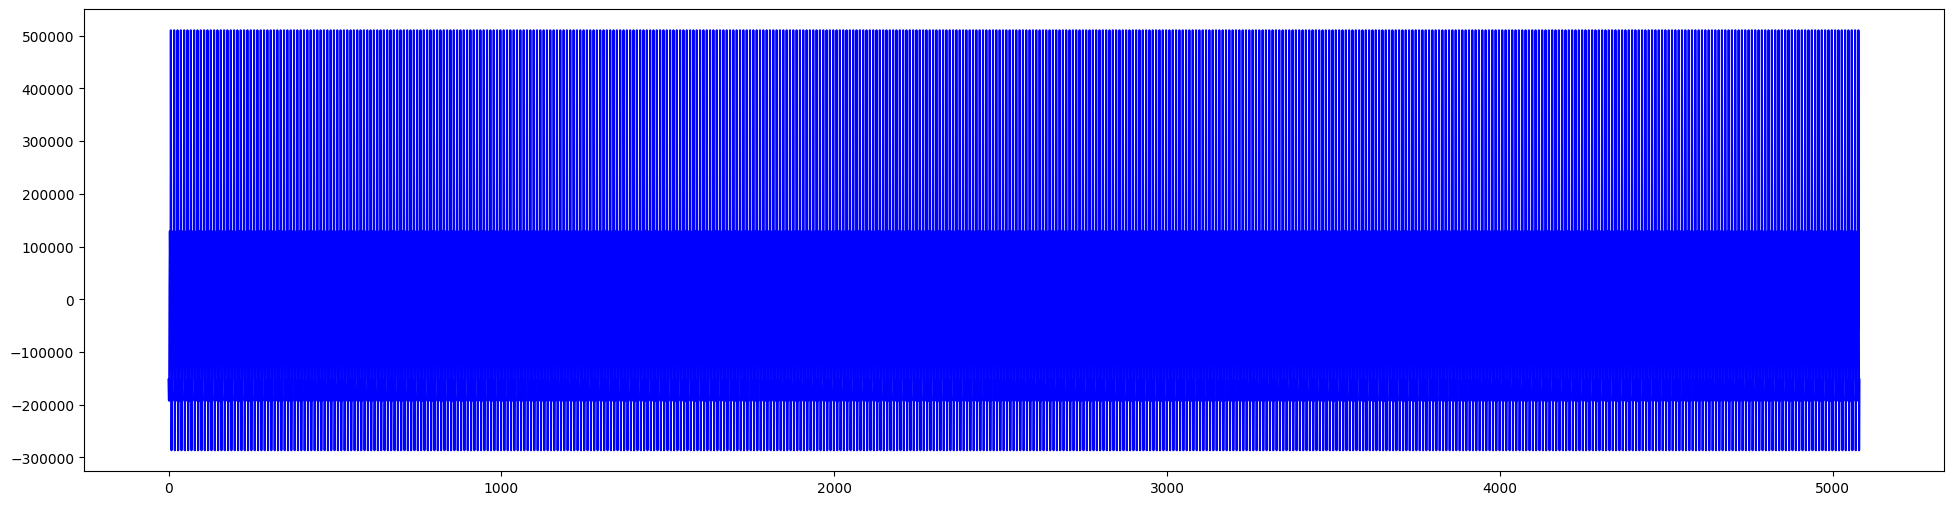

In [224]:
m_data =train['vol-seasonal']
m_data.plot(color='blue', figsize=(24,6))

Augmented Dickey-Fuller is a statitical test for stationary-ness. Test returns a p-val of 0.63 indicating that the null hypothesis is incorrect and that the data is not stationary. 

### Fit Model

In [225]:
# Some tools 

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

#### Autocorrelations? 

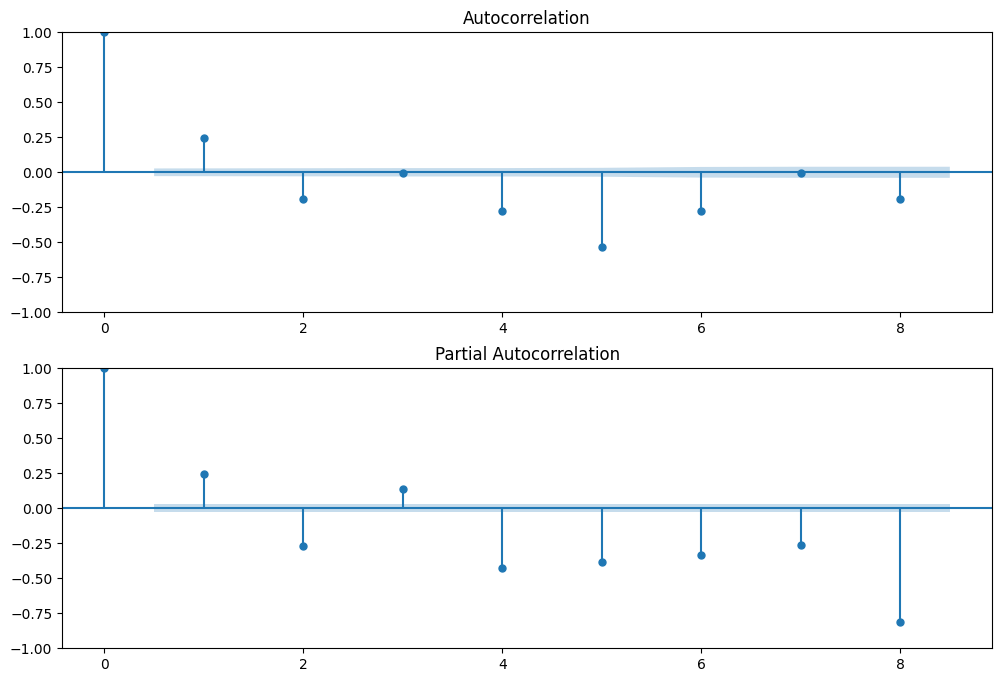

In [229]:
m_data = m_data.dropna()
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(m_data, lags=8, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(m_data, lags=8, ax=ax2)



### Fit Model

In [232]:
arima_1_0_0 = ARIMA(train['vol-seasonal'], order=(1, 0, 0)).fit()
print(arima_1_0_0.summary())

                               SARIMAX Results                                
Dep. Variable:           vol-seasonal   No. Observations:                 5081
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -69578.148
Date:                Mon, 31 Oct 2022   AIC                         139162.296
Time:                        15:55:45   BIC                         139181.895
Sample:                             0   HQIC                        139169.159
                               - 5081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.9679   4028.748     -0.007      0.994   -7926.170    7866.234
ar.L1          0.2415      0.027      8.801      0.000       0.188       0.295
sigma2       4.59e+10      0.011   4.14e+12      0.0

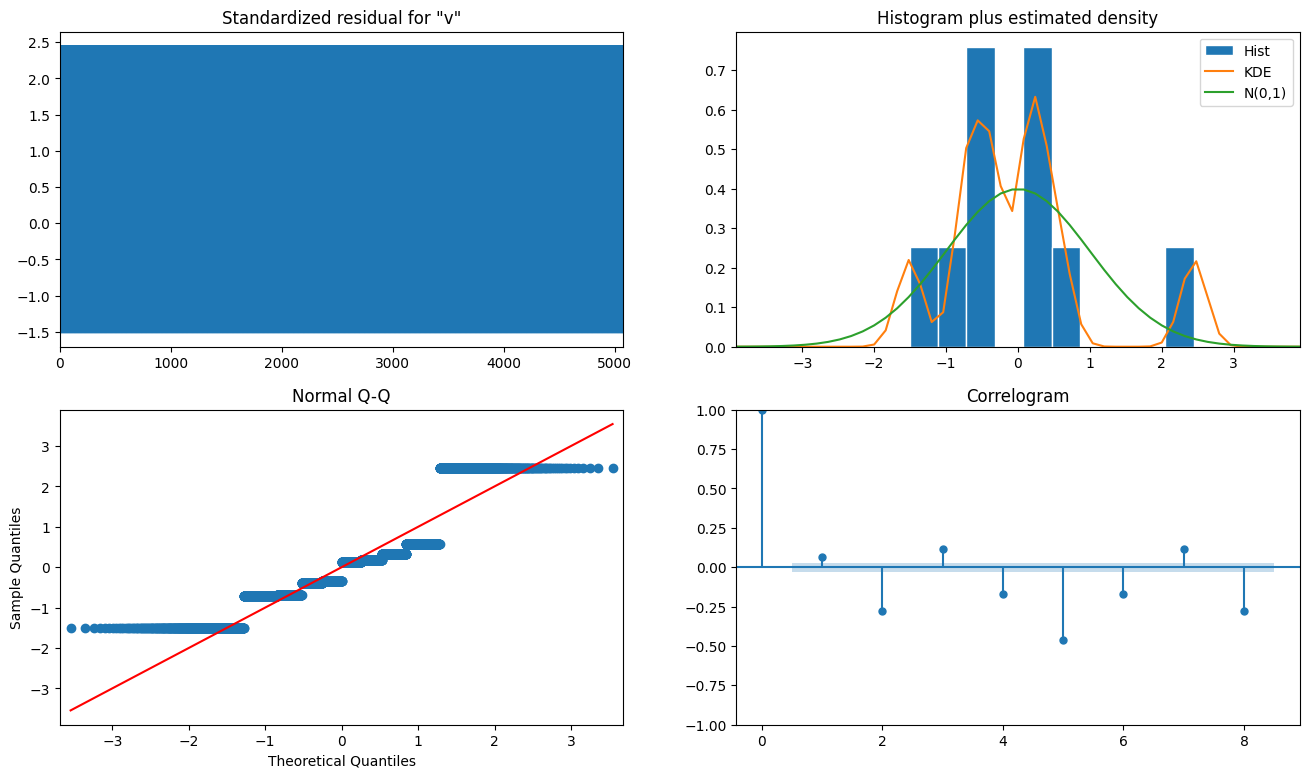

In [235]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_0_0.plot_diagnostics(fig=fig, lags=8)

In [248]:
arima_2_0_1 = ARIMA(train['vol-seasonal'], order=(2, 0, 1)).fit()
print(arima_2_0_1.summary())


                               SARIMAX Results                                
Dep. Variable:           vol-seasonal   No. Observations:                 5081
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -69215.107
Date:                Mon, 31 Oct 2022   AIC                         138440.213
Time:                        21:20:13   BIC                         138472.879
Sample:                             0   HQIC                        138451.653
                               - 5081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.9679   4370.342     -0.007      0.995   -8595.681    8535.745
ar.L1         -0.2407      0.043     -5.539      0.000      -0.326      -0.156
ar.L2         -0.1609      0.027     -5.913      0.0

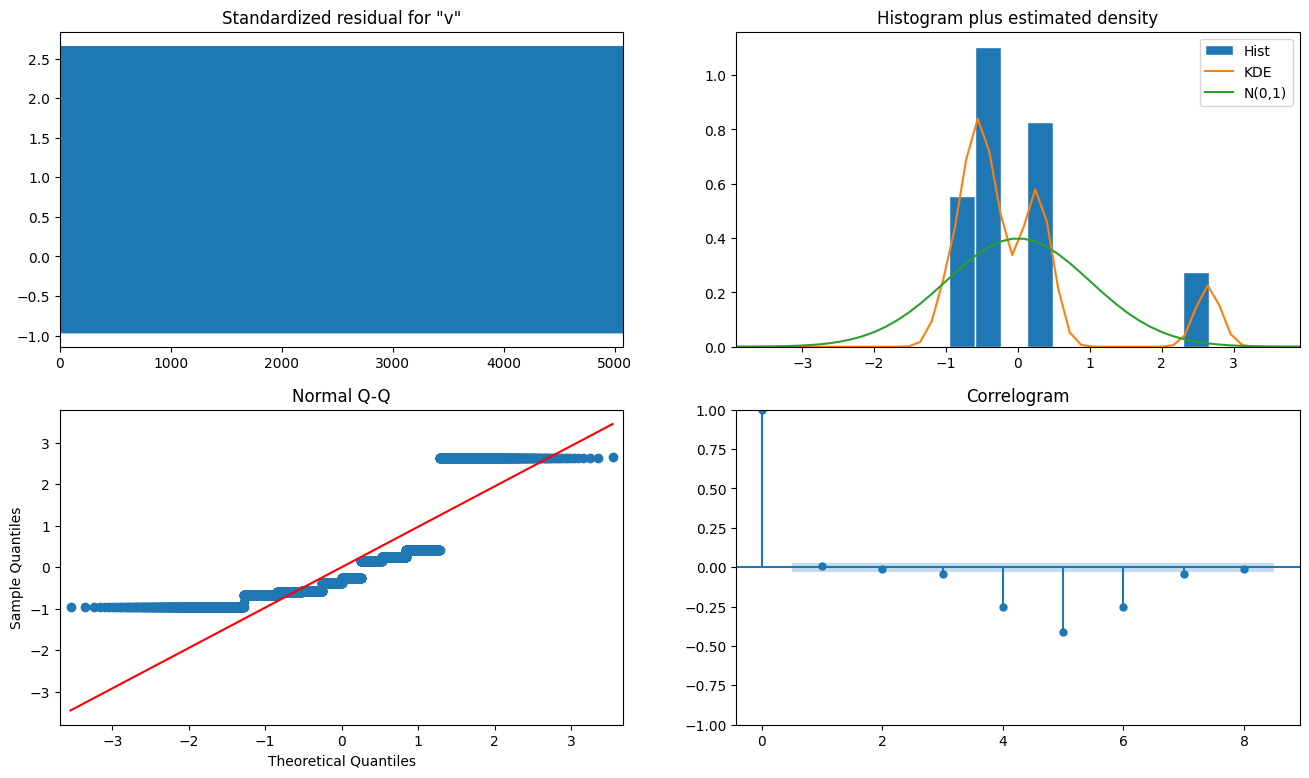

In [237]:
fig = plt.figure(figsize=(16, 9))
fig = arima_2_0_1.plot_diagnostics(fig=fig, lags=8)

Some comments about goodness of fit. 

### Forcast with ARIMA

In [249]:
arima_fcst = arima_2_0_1.get_forecast(steps=8)
arima_predictions = pd.DataFrame(arima_fcst.predicted_mean)
arima_predictions.rename(columns={"predicted_mean": "trend"}, inplace=True)

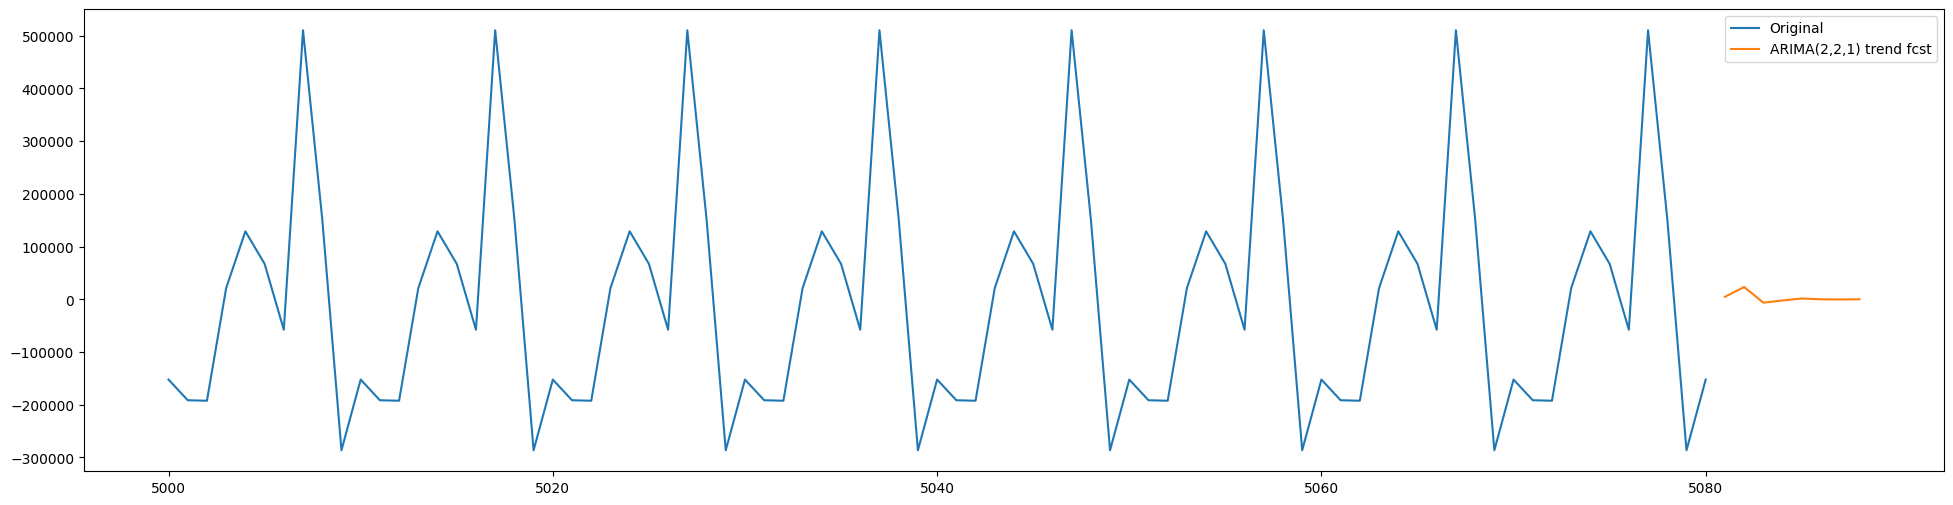

In [252]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train['vol-seasonal'][5000:].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,0,1) trend fcst", ax=ax_arima_fcst)
plt.legend()


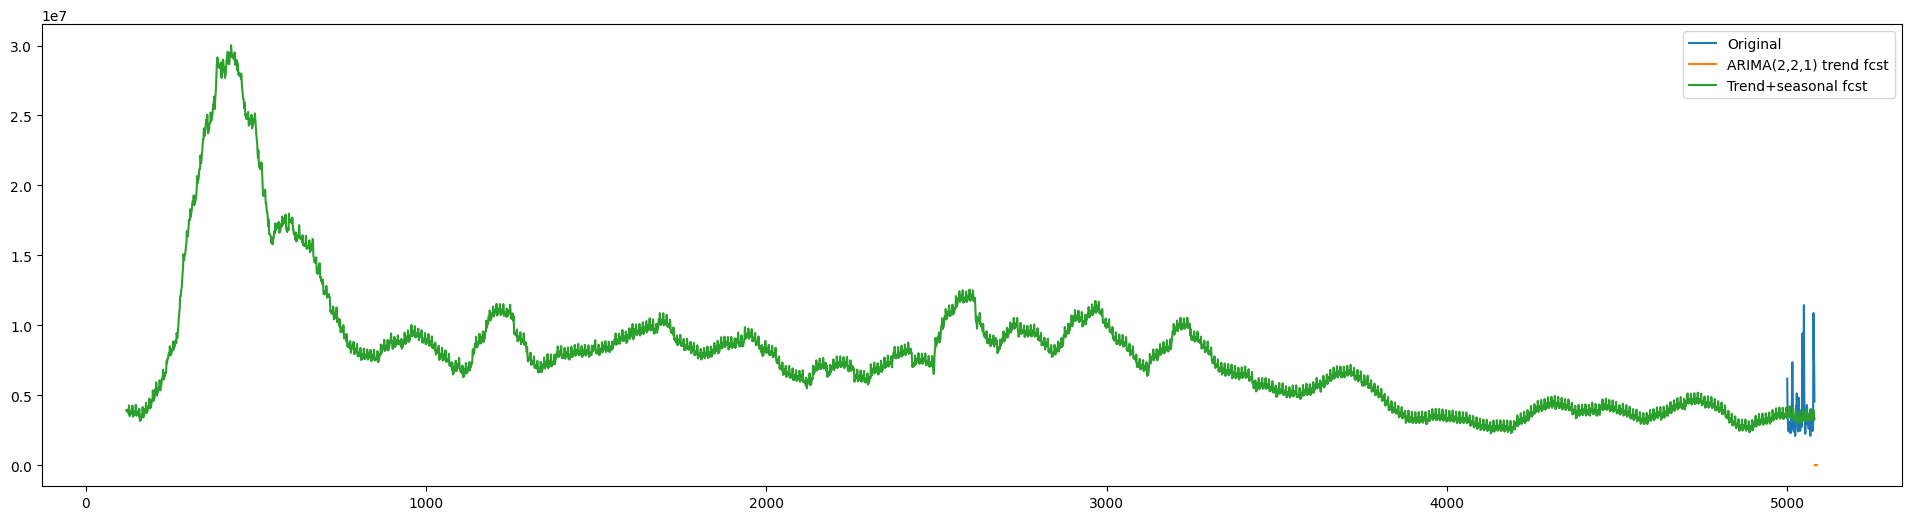

In [273]:
arima_predictions['trend+seasonal'] = train['vol-seasonal']+train['MA-120']

fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train['Volume'][5000:].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
(train['vol-seasonal']+train['MA-120'])[:].plot(label="Trend+seasonal fcst", ax=ax_arima_fcst)
plt.legend()

In [271]:
arima_predictions['trend+seasonal'].shape

(8,)